## [Description](#Description_)
- ### [**(1 балла) Задание 1.** Знакомство с данными.](#**(1_балла)_Задание_1.**_Знакомство_с_данными._)
- ### [**(1 балла) Задание 2.** Организация валидации.](#**(1_балла)_Задание_2.**_Организация_валидации._)
- ### [**(0.5 балла) Задание 3.** Базовые решения.](#**(0.5_балла)_Задание_3.**_Базовые_решения._)
- ### [**(1.0 балла) Задание 4.** Метрики качества.](#**(1.0_балла)_Задание_4.**_Метрики_качества._)
- ### [**(1.0 балла) Задание 5.** Метод Memory based. User-2-User or Item-2-Item.](#**(1.0_балла)_Задание_5.**_Метод_Memory_based._User-2-User_or_Item-2-Item_)
- ### [**(0.5 балла) Задание 6.** SVD.](#**(0.5_балла)_Задание_6.**_)
- ### [**(1.0 балла) Задание 7.** ALS.](#**(1.0_балла)_Задание_7.**_)
- ### [**(1.0 балла) Задание 8.** LightFM.](#**(1.0_балла)_Задание_8.**_LightFM_)
- ### [**(1.0 балла) Задание 9.** Catboost.](#**(1.0_балла)_Задание_9.**_Catboost._)
## [Imports](#Imports_)
## [Globals](#Globals_)
## [Utils](#Utils_)
- ### [Markdown](#Markdown_)
- ### [Yadisk](#Yadisk_)
- ### [Web](#Web_)
- ### [File](#File_)
## [Setup](#Setup_)

## Imports <span id=Imports_></span>

In [157]:
%load_ext nb_black

import collections
import dataclasses
import einops
import functools
import glob
import matplotlib.pyplot as plt
import numba
from numba import njit
import numpy as np
import os
import pandas as pd
import requests
import scipy
from scipy.sparse import csr_matrix, coo_matrix, spmatrix
import sklearn
import sys
import torch
import types
from typing import Callable, Literal, TypeVar
from tqdm.auto import tqdm
import urllib
import wandb

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## Globals <span id=Globals_></span>

In [70]:
CONFIG = types.SimpleNamespace()

DATA = types.SimpleNamespace()

MODEL = types.SimpleNamespace()

<IPython.core.display.Javascript object>

## Utils <span id=Utils_></span>

### Markdown <span id=Markdown_></span>

In [71]:
def make_new_markdown_section_with_link(section, header_size: int = 2, do_print=True):
    header = "#" * header_size
    section_id = section.replace(" ", "_") + "_"
    section_link = f"{header} [{section}](#{section_id})"
    section_header = f"{header} {section} <span id={section_id}></span>"
    if do_print:
        print(section_link + "\n" + section_header)
    return section_link, section_header

<IPython.core.display.Javascript object>

### Yadisk <span id=Yadisk_></span>

In [72]:
def get_yadisk_download_url(
    yadisk_url: str,
    base_url="https://cloud-api.yandex.net/v1/disk/public/resources/download?",
) -> str:
    final_url = base_url + urllib.parse.urlencode(dict(public_key=yadisk_url))
    response = requests.get(final_url)
    download_url = response.json()["href"]
    return download_url

<IPython.core.display.Javascript object>

### Web <span id=Web_></span>

In [73]:
def write_response_content_to_file(url: str, filename: str) -> None:
    download_response = requests.get(url)
    with open(filename, "wb") as f:
        f.write(download_response.content)

<IPython.core.display.Javascript object>

### File <span id=File_></span>

In [74]:
def unzip(zip_path, save_path=None, delete_zip=False):
    !unzip {zip_path} {"-d "+ save_path if save_path else ""}
    if delete_zip:
        for path in glob.glob(zip_path):
            if path.endswith(".zip"):
                !trash {path}

<IPython.core.display.Javascript object>

## Setup <span id=Setup_></span>

In [75]:
DATA.yadisk_url = "https://disk.yandex.ru/d/9yMyAhVNw_tvLA"
DATA.filename = "data/lab_recommending"

<IPython.core.display.Javascript object>

In [76]:
for url, filename in tqdm(
    zip(
        [DATA.yadisk_url],
        [DATA.filename],
    )
):
    if not os.path.exists(filename):
        zip_filename = filename + ".zip"
        write_response_content_to_file(
            url=get_yadisk_download_url(yadisk_url=url),
            filename=zip_filename,
        )
        unzip(zip_path=zip_filename, save_path=filename, delete_zip=True)

0it [00:00, ?it/s]

<IPython.core.display.Javascript object>

## Data <span id=Data_></span>

In [77]:
!ls data/lab_recommending/data

aspects.csv       organisations.csv rubrics.csv       users.csv
features.csv      reviews.csv       test_users.csv


<IPython.core.display.Javascript object>

In [78]:
DATA.folder = "data/lab_recommending/data"
DATA.dataframes: dict[str, pd.DataFrame] = {}

for filename in os.listdir(DATA.folder):
    DATA.dataframes[os.path.splitext(filename)[0]] = pd.read_csv(
        os.path.join(DATA.folder, filename)
    )

/var/folders/5w/gytwm8sd6vldh9ym3dvj_x_m0000gn/T/ipykernel_61557/492296409.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  DATA.dataframes[os.path.splitext(filename)[0]] = pd.read_csv(


<IPython.core.display.Javascript object>

## Description <span id=Description_></span>

### Кошман Дмитрий

# Бонусная лабораторная работа 9. Часть 2. Рекомендательные системы.



Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 8 баллов. Сдавать задание после указанного в lk срока сдачи нельзя. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, нам необходима ссылка на источник).



## Знакомство с данными

### Рекомендация организаций, которые получат высокий отзыв от пользователя, когда он гостит в чужом для себя городе

Данные подготовлены по аналогии с конкурсом https://yandex.ru/cup/ml/.
Выражаем благодарность Сураджу Сингху за помощь в подготовке данных.


Легенда исходного соревнования:

Иннокентий — москвич в пятом поколении. 

Блуждание между тремя тополями на Плющихе, ежемесячное посещение Мавзолея, кормление тапиров в Московском зоопарке — всё это в крови Иннокентия.

Помимо этого, Иннокентий очень любит поесть. Как типичный среднестатистический москвич, Иннокентий посещает исключительно рестораны со средним чеком от 5000 рублей, любит устрицы и хорошие стейки зернового откорма, избегает кафе с шаурмой — боится, что его нечаянно накормят шавермой. Будучи добропорядочным горожанином, Иннокентий исправно оставляет на *Яндекс.Картах* отзывы на посещенные рестораны, живописно описывая свой гастрономический опыт.

Однажды Иннокентий понимает, что за пределами МКАД лежит целый мир, дикий и неизведанный. Он решается на самое опасное и рискованное путешествие в своей жизни — посещение Санкт-Петербурга. Иннокентий выбрал поезд на *Яндекс.Расписаниях*, забронировал отель на *Яндекс.Путешествиях* и отправился в путь.

Выйдя утром из вагона поезда «Красная Стрела», Иннокентий опасливо огляделся и решил хорошо подкрепиться. Дело за малым — подобрать хороший ресторан, удовлетворяющий его утонченным вкусам. Рекомендации друзей оказались бесполезны, ведь все они москвичи и плохо разбираются в петербургских гастрономических трендах. Давайте поможем Иннокентию найти вкусную еду.

В этой задаче вам предстоит построить рекомендательную систему, которая предложит пользователям *Яндекс.Карт* соответствующие их вкусу кафе, бары и рестораны в неродном городе: москвичам — в Санкт-Петербурге, а петербуржцам — в Москве. 

В качестве данных используйте анонимизированную информацию о реальных отзывах и оценках, оставляемых пользователями Яндекс.Карт на заведения общепита Москвы и Санкт-Петербурга, и различную информацию о самих заведениях. 

В частности, каждый отзыв содержит множество аспектов (упомянутые в отзыве блюда, особенности и т. п.), извлеченных из отзыва с помощью NLP-алгоритма. Для заданного множества москвичей и петербуржцев нужно предсказать, какие заведения в неродном городе они посетят, оставив при этом положительный отзыв с оценкой 4 или 5.


Архив с данными можно найти [здесь](https://disk.yandex.ru/d/9yMyAhVNw_tvLA).




Обучающее множество собрано за X = 1277 дней, тестовое множество – за последующие Y = 107 дней.

**reviews.csv**

В этом файле дана информация об отзывах и оценках, оставленных некоторым множеством жителей Москвы и Санкт-Петерубрга в течение обучающего периода: 


```
user_id,org_id,ts,rating,aspect_ids
18a7276b,14e1b7bb,120,4,2 4 23
...
```

* user_id: идентификатор пользователя
* org_id: идентификатор организации
* ts: время отзыва (в днях от начала обучающего периода)
* rating: поставленная оценка
* aspect_ids: набор упомянутых в тексте отзыва аспектов.

**organisations.csv**

Информация об организациях:

```
org_id,city,average_bill,rubric_id,avg_rating,feature_ids
14e1b7bb,msk,2000,6,4.3,3 5 14 28
0ed69bff,spb,1500,2,4.8,2 5 6
...
```

* org_id: идентификатор организации
* city_id: город организации
* average_bill: средний чек в рублях (округленный с точностью до 500 рублей)
* avg_rating: средний рейтинг (в том числе с учетом не перечисленных в файле reviews.csv отзывов и оценок)
* rubric_id: рубрика опрганизации
* feature_ids: набор известных особенностей данной организации.

**users.csv**

Информация о городе проживания пользователя:

```
user_id,city
18a7276b,msk
270cc9fee,spb
4bf7ffc,msk
...
```

**aspects.csv**

Описание извлекаемых из отзывов аспектов. Множество аспектов извлекается из отзыва с помощью NLP-алгоритма и может быть неточным.

```
aspect_id,aspect_name
1,Бургеры
2,Кофе
3,Интерьер
4,Веранда
5,Устрицы
...
```

**features.csv**

Описание особенностей организаций. Как правило, множество особенностей организации заполняется ее владельцем и может быть неточным.

```
feature_id,feature_name
1,Wi-Fi
2,Доставка
3,Кофе с собой
...
```

**rubrics.csv**

Описание рубрик организаций:

```
rubric_id,rubric_name
1,Ресторан
2,Кафе
3,Бар
...
```

**test_users.csv**

Множество пользователей, для которых необходимо сделать предсказание:

```
user_id
270cc9fee
4bf7ffc
...
```

### **(1 балла) Задание 1.** Знакомство с данными. <span id=**(1_балла)_Задание_1.**_Знакомство_с_данными._></span>

В первую очередь нам понадобятся данные по __пользователям__ (в терминах recsys -- usesr), __организациям__ (в терминах recsys -- items) и сами __отзывы__ (в терминах recsys -- ratings или explicit feedback). 

На основании этих данных можно будет проводить базовый анализ методами колаборативной фильтрации.

  * Опишите, насколько активно пользователи оставляют отзывы, насколько активно организации получают отзывы.
  * Предложите стратегии фильтрации данных.
  


Во вторую очередь нас будут инетересовать атрибуты организаций: aspects, features, rubrics.
Проанализируйте эти таблицы. Какие признаки для описания организаций и пользователей из них можно извлечь?


In [79]:
def describe_review_counts(
    df,
    reviews,
    axis,
    title,
    quantiles=(0, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99, 0.999, 0.9999, 1),
    quantiles_to_plot=(0.5, 0.99, 0.999, 0.9999),
    plt_kwargs=None,
    cmap="hsv",
):
    reviews_count = reviews.groupby(df.index.name).size().reindex(df.index)
    reviews_count.plot(ax=axis, title=title, **(plt_kwargs or {}))
    axis.set_xlabel(plt_kwargs.get("xlabel"))
    axis.set_ylabel(plt_kwargs.get("ylabel"))

    for i, q in enumerate(quantiles_to_plot, start=1):
        quantile = reviews_count.quantile(q=q)
        axis.axvline(quantile, ls="--", c=plt.get_cmap(name=cmap)(q))
        axis.text(quantile, axis.get_ylim()[1] / 2**i, f"{100*q}%", ha="left")

    return reviews_count.agg(
        {
            "mean": pd.Series.mean,
            "std": pd.Series.std,
            **{
                f"{100*q}%": functools.partial(pd.Series.quantile, q=q)
                for q in quantiles
            },
        }
    )


def show_review_counts(users, items, ratings):
    fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
    plt_kwargs = dict(
        kind="hist",
        log=True,
        histtype="stepfilled",
        bins=100,
        edgecolor="black",
        facecolor="gray",
        alpha=0.5,
        xlabel="Reviews count",
        ylabel="Frequency (log scale)",
    )
    return pd.DataFrame(
        {
            title: describe_review_counts(
                df,
                ratings,
                axis,
                title=title,
                plt_kwargs=plt_kwargs,
            )
            for df, axis, title in zip(
                [users, items],
                axes,
                ["Users reviews written", "Organisations reviews received"],
            )
        }
    ).T

<IPython.core.display.Javascript object>

* Опишите, насколько активно пользователи оставляют отзывы, насколько активно организации получают отзывы.

,mean,std,0%,25.0%,50.0%,75.0%,90.0%,95.0%,99.0%,99.9%,99.99%,100%
Users reviews written,2.964589,4.854616,1.0,1.0,1.0,3.0,6.0,10.0,22.0,54.000,117.0000,611.0
Organisations reviews received,60.429564,436.475347,1.0,2.0,8.0,32.0,125.0,246.0,785.0,3021.324,15019.8882,61520.0


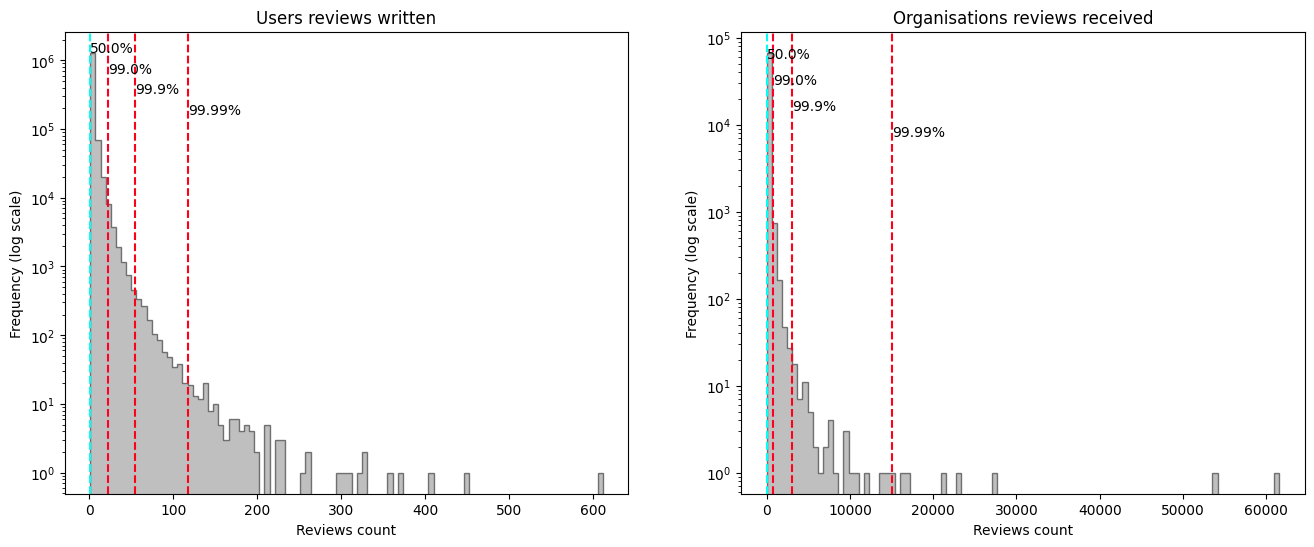

<IPython.core.display.Javascript object>

In [80]:
show_review_counts(
    users=DATA.dataframes["users"].set_index("user_id"),
    items=DATA.dataframes["organisations"].set_index("org_id"),
    ratings=DATA.dataframes["reviews"],
)

* Предложите стратегии фильтрации данных.

Отбросить организации, у которых мало оценок и все они негативные. Это наименее полезные для нас организации, поскольку они одновременно не дают много информации о взаимных интересах пользователей, и не пригодятся для конечных рекомендаций.

Реализация этой стратегии может выглядеть так: мы сортируем организации по значению функции полезности

$$f(\text{organisation}) = (\text{rating count})(1 + \text{rating std})^\alpha (\text{mean rating})^\beta$$

И отсекаем $\gamma$ первых организаций, где $\alpha, \beta$ и $\gamma$ подбираются по нашим предпочтениям.

In [81]:
def debug_data_split(data, debug_partition=0.1):
    data["reviews"] = data["reviews"][: int(len(data["reviews"]) * debug_partition)]
    reviews_user_ids = data["reviews"].user_id
    data["users"] = (
        data["users"].query("user_id in @reviews_user_ids").reset_index(drop=True)
    )
    data["test_users"] = data["test_users"].query("user_id in @reviews_user_ids")
    reviews_org_ids = data["reviews"].org_id
    data["organisations"] = (
        data["organisations"].query("org_id in @reviews_org_ids").reset_index(drop=True)
    )
    return data

<IPython.core.display.Javascript object>

In [82]:
DATA.dataframes = debug_data_split(DATA.dataframes)

<IPython.core.display.Javascript object>

In [83]:
class Preprocessor:
    @staticmethod
    def filter(reviews, alpha=1, beta=1, gamma=0.9):
        reviews = reviews.dropna(subset=["rating"])
        usefulness = reviews.groupby("org_id").apply(
            functools.partial(
                Preprocessor.calculate_usefulness, alpha=alpha, beta=beta
            ),
        )
        org_ids_to_keep = usefulness.sort_values().index[
            -int(gamma * len(usefulness)) :
        ]
        return reviews.query("org_id in @org_ids_to_keep")

    @staticmethod
    def calculate_usefulness(org_df, alpha, beta):
        usefulness = (
            len(org_df)
            * (1 + org_df["rating"].std(ddof=0)) ** alpha
            * org_df["rating"].mean() ** beta
        )
        return usefulness

    @staticmethod
    def single_train_test_split(reviews, fraction_of_max_possible_test_size):
        ts_grouped_by_user_id = reviews.groupby("user_id")["ts"]
        ranks = ts_grouped_by_user_id.rank(method="first").rename("rank")
        sizes = ts_grouped_by_user_id.size().rename("size")
        test_prob = (
            reviews[["user_id"]]
            .join(ranks)
            .join(sizes, on="user_id")
            .pipe(lambda df: (df["rank"] - 1) / (df["size"] - 1).replace({0: 1}))
            .pipe(lambda s: s / s.sum())
        )
        max_possible_test_size = test_prob.astype(bool).sum()

        np.random.seed(42)

        test_index = np.random.permutation(
            np.random.choice(
                reviews.index,
                size=int(fraction_of_max_possible_test_size * max_possible_test_size),
                replace=False,
                p=test_prob,
            )
        )
        test = reviews.loc[test_index]
        train = reviews.drop(test_index).query("user_id in @test.user_id")
        return train, test

    @staticmethod
    def train_test_split(reviews, test_fractions):
        total_test_fraction = sum(test_fractions)
        train, test = Preprocessor.single_train_test_split(reviews, total_test_fraction)
        test_sizes = [int(len(test) * i / total_test_fraction) for i in test_fractions]
        test_splits = []
        for begin, end in zip(np.cumsum([0] + test_sizes), np.cumsum(test_sizes)):
            test_splits.append(test.iloc[begin:end])

        return train, test_splits

    def build_ids_map(self, users, organisations):
        self.user_id_map = users["user_id"].reset_index(drop=True)
        self.reverse_user_id_map = pd.Series(
            self.user_id_map.index, self.user_id_map.values
        ).sort_index()

        self.org_id_map = organisations["org_id"].reset_index(drop=True)
        self.reverse_org_id_map = pd.Series(
            self.org_id_map.index, self.org_id_map.values
        ).sort_index()

    def map_ids(self, df):
        if "user_id" in df:
            df["user_id"] = df["user_id"].map(self.reverse_user_id_map)
            df = df.astype({"user_id": np.int32})

        if "org_id" in df:
            df["org_id"] = df["org_id"].map(self.reverse_org_id_map)
            df = df.astype({"org_id": np.int32})

        return df

<IPython.core.display.Javascript object>

Во вторую очередь нас будут инетересовать атрибуты организаций: aspects, features, rubrics.
Проанализируйте эти таблицы. Какие признаки для описания организаций и пользователей из них можно извлечь?


Эти таблицы содержат текстовые описания, так что можно взять их эмбединги или обучить латентные векторные представления, либо кластеризовать и взять метки кластеров, и использовать все это в качестве дополнительных признаков.

### **(1 балла) Задание 2.** Организация валидации. <span id=**(1_балла)_Задание_2.**_Организация_валидации._></span>

В оригинальном соревновании, обучающее множество было собрано за X = 1277 дней, тестовое множество – за последующие Y = 107 дней.

И хотя в этом году соревнование мы не проводим, давайте организуем у себя валидацию схожим образом, т.е. по времени.

Раз мы будем еще и осуществлять выбор моделей, то следует произвести расщепление по времнеи на 3 группы train validation и holdout.

Как уже говрилось на семинаре, для повышения качества локальной валидации, можно сделать скользящую валидацию. В самой лабораторной работе мы так делат не будем, но для конкурса имейте это в виду.

**N.B.** У нас не получится честно сэмулировать колонку aspect_ids, т.к. для этого потребуется доступ к сырым данным, котрых у нас не будет в данной лабораторной работе. Будет ли это являться большим ликом -- факультативный вопрос, который мы оставим за скобками лабораторной.

In [84]:
preprocessor = Preprocessor()
preprocessor.build_ids_map(DATA.dataframes["users"], DATA.dataframes["organisations"])
for key, df in DATA.dataframes.items():
    DATA.dataframes[key] = preprocessor.map_ids(df)

<IPython.core.display.Javascript object>

In [85]:
train_reviews, (validation_reviews, holdout_reviews) = preprocessor.train_test_split(
    DATA.dataframes["reviews"], test_fractions=[0.25, 0.25]
)

<IPython.core.display.Javascript object>

### **(0.5 балла) Задание 3.** Базовые решения. <span id=**(0.5_балла)_Задание_3.**_Базовые_решения._></span>

Сделаем базовые решения:
  * Для каждого пользователя выдаём 20 случайных организаций
  * Для каждого пользователя выдаём самые популярные организации в неродном городе

In [93]:
def to_scipy_coo(sparse_matrix: torch.Tensor or spmatrix) -> coo_matrix:
    if not torch.is_tensor(sparse_matrix):
        return sparse_matrix.tocoo()
    sparse_matrix = to_sparse_coo(sparse_matrix).coalesce().cpu()
    sparse_matrix = coo_matrix(
        (sparse_matrix.values().numpy(), sparse_matrix.indices().numpy()),
        shape=sparse_matrix.shape,
    )
    return sparse_matrix


class RandomRecommender:
    def fit(self, reviews):
        self.org_ids = reviews["org_id"].unique()
        return self

    def recommend(self, user_ids, n_recommendations=10):
        ratings = torch.randn(len(user_ids), n_recommendations)
        return ratings


class PopularRecommender:
    def fit(self, reviews):
        self.org_ids = reviews["org_id"].unique()

        row = reviews["user_id"].values
        col = reviews["org_id"].values
        data = np.ones_like(row)
        explicit = scipy.sparse.coo_matrix((data, (row, col)))
        implicit_feedback = to_scipy_coo(explicit) > 0
        self.items_count = torch.from_numpy(implicit_feedback.sum(axis=0).A.squeeze(0))

    def recommend(self, user_ids, n_recommendations=10):
        ratings = self.items_count[:n_recommendations].repeat(len(user_ids), 1)
        return ratings.to(torch.float32)

<IPython.core.display.Javascript object>

### **(1.0 балла) Задание 4.** Метрики качества. <span id=**(1.0_балла)_Задание_4.**_Метрики_качества._></span>

Напомним, что у нас бинарная релевантнотсь на основе оценки вычисляется как предикат **оценка больше, чем 3**.

Реализуйте набор метрик качества (можете оборачивать внешние паекты):
   * MNAP@20 (как в описании соревнования)
   * HitRate ( = 1, если среди рекомендаций есть хотя бы одна релевантная и 0 иначе)
   * MRR@20 ( обратная позиция первой релевантной рекомендации из списка рекомендаций длины K. )
   * Coverage (доля item-ов, учитываемых в рекомендациях)
   * Surprisal(см. ниже) 


### Surprisal
Посмотирм, насколько наши рекомендации хороши с точки зрения новизны для пользователя, в качестве новизны будем рассматривать "непопулярность" айтемов в рекомендациях.

Будем рассматривать собственную информацию item-а как меру его новизны.

$$selfInformation(i) = -\log_2 \frac{|u_i|}{|N|}$$, 
где 
$i$ - объект, $|N|$ - число взаимодействий в обучающей выборке,  $|u_i|$ - число пользователей, взаимодействовавших с объектом в обучающей выборке.

После подсчета собственной информации усредним значения собственной информации в рекомендациях пользователя.

Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u)@k = \frac{1}{k \cdot log_2 N} \sum_{j = 1}^{k}selfInformation(i_{u,j})$$

где $i_{u,j}$ это j-й объект, который мы порекомендововали пользователю.

Получившаяся метрика похожа на энтропию Шеннона:
$$H = - K \sum_{i\in R}{p_i log p_i}$$


Результа усредним по пользователям.

### Что нужно сделать
    
  * Создайте функцию, которая генерирует словарь с метриками, по предоставленному решению.

  * Оцените baseline-решения на валидации.

In [94]:
def relevant_pairs_to_frame(relevant_pairs):
    relevant_pairs = pd.DataFrame(relevant_pairs)
    relevant_pairs.columns = ["user_id", "item_id"]
    return relevant_pairs


@njit
def mark_duplicate_recommended_items_as_invalid(recommendations, invalid_mark=-1):
    """Mark all but first duplicated items as invalid for each user.
    :param recommendations: array of shape [n_users, n_items] with recommended item_ids
    :param invalid_mark: integer to replace duplicates with
    :return: recommendations array with duplicated values in each row marked as invalid,
    keeping the first occurrence.
    """
    for user, recommended_items in enumerate(recommendations):
        occurred_item_ids = []
        for item_rank, item in enumerate(recommended_items):
            if item in occurred_item_ids:
                recommendations[user, item_rank] = invalid_mark
            else:
                occurred_item_ids.append(item)
    return recommendations


def binary_relevance(explicit_feedback, recommendee_user_ids, recommendations):
    """
    Determine whether recommended items are relevant to users based on provided relevant pairs.
    :param explicit_feedback: csr_matrix with explicit feedback
    :param recommendee_user_ids: numpy array of shape [n_users] indicating users for whom the
    recommendations were generated.
    :param recommendations: numpy array of shape [n_users, n_items] with recommended item ids,
    with each row corresponding to user_id from recommendee_user_ids, with items sorted in
    decreasing predicted relevance.
    :return: numpy bool array of shape [n_users, n_items] indicating whether the recommended
    [user_id, item_id] pair is in relevant_pairs.
    """
    explicit = explicit_feedback[recommendee_user_ids]
    relevance = njit_binary_relevance(
        explicit.indptr, explicit.indices, recommendations
    )
    return relevance


@njit
def njit_binary_relevance(indptr, indices, recommendations):
    relevance = np.zeros_like(recommendations)
    for i, (begin, end, item_ids) in enumerate(
        zip(indptr, indptr[1:], recommendations)
    ):
        for j, item_id in enumerate(item_ids):
            relevance[i, j] = item_id in indices[begin:end]
    return relevance


def hitrate(relevance):
    """
    Returns proportion of users who were hit (were recommended at least one relevant item).
    This metric is pretty basic and represents an upper bound on other metrics
    and the model performance in general.

    :param relevance: boolean array of shape [n_users, n_items], representing
    relevant recommendations per user.
    """
    hits_per_user = einops.reduce(relevance, "user relevance -> user", np.any)
    return np.mean(hits_per_user)


def accuracy(relevance):
    """Average proportion of relevant recommendations."""
    return np.mean(relevance)


def mean_reciprocal_rank(relevance):
    """
    Returns average reciprocal rank, i.e. 1 / position, of first relevant item per user.
    Represents how far users have to explore their recommendations before encountering
    something relevant.
    """
    reciprocal_ranks = 1 / np.arange(1, relevance.shape[1] + 1)
    relevant_ranks = np.einsum("i j, j -> i j", relevance, reciprocal_ranks)
    first_relevant_rank = einops.reduce(relevant_ranks, "user rank -> user", np.max)
    return np.mean(first_relevant_rank)


def number_of_all_relevant_items_per_user(relevant_pairs, recommendee_user_ids):
    return (
        relevant_pairs_to_frame(relevant_pairs)
        .groupby("user_id")
        .size()
        .loc[recommendee_user_ids]
        .fillna(0)
        .astype(np.int32)
        .to_numpy()
    )


def recall(relevance, n_relevant_items_per_user):
    """
    Proportion of retrieved relevant items among all
    known to be relevant for each user.
    Very sensitive to size of recommendations.
    """
    return np.mean(
        einops.reduce(relevance, "user item -> user", "sum")
        / np.where(n_relevant_items_per_user == 0, 1, n_relevant_items_per_user)
    )


def mean_average_precision(relevance, n_relevant_items_per_user):
    """
    This metric represents average proportion of relevant items at every possible cutoff.
    While metrics generally try to keep their image equal to the [0, 1] interval, value of 1 is
    unreachable if user has no relevant items. This metric suffers from this downside the
    most, so it needs to know maximum possible number of relevant items per user to
    normalize its image to the [0, 1] interval.
    """

    reciprocal_ranks = 1 / np.arange(1, relevance.shape[1] + 1)
    n_relevant_items_at_k = np.cumsum(relevance, axis=1)
    precision_at_k = np.einsum("i j, j -> i j", n_relevant_items_at_k, reciprocal_ranks)
    average_precision = np.einsum(
        "i j, i j, i -> i",
        precision_at_k,
        relevance,
        1 / np.maximum(n_relevant_items_per_user, 1e-8),
    )
    return np.mean(average_precision)


def coverage(recommendations, all_possible_item_ids):
    """
    Coverage represents the proportion of items that ever get recommended.
    This metric is very sensitive to the structure of recommendations, so it is
    more of a debug kind of metric and useful only when comparing models
    with same queried users and same number of recommendations.

    :param recommendations: array of shape [n_users, n_items] with recommended item ids
    :param all_possible_item_ids: array or set with all item_ids from training dataset
    """
    all_items = set(all_possible_item_ids)
    return len(set(recommendations.flat) & all_items) / len(all_items)


def normalized_items_self_information(explicit_feedback):
    """
    Computes self information of each item, representing how much information
    an item occurrence brings. The higher the information, the more niche the
    item is.
    :return: pandas Series with item ids in index and self information in values
    """
    explicit_feedback = explicit_feedback.tocoo()
    relevant_pairs = np.stack([explicit_feedback.row, explicit_feedback.col]).T
    relevant_pairs = relevant_pairs_to_frame(relevant_pairs)
    n_item_interactions = relevant_pairs.groupby("item_id").size()
    information = np.log2(len(relevant_pairs)) - np.log2(n_item_interactions)
    assert (
        information.notna().all()
    ), f"Debug: Self information shouldn't be na, {information}"
    return information / np.log2(len(relevant_pairs))


@njit
def jit_surpisal(item_ids, self_information_per_item, recommendations):
    self_information = {i: j for i, j in zip(item_ids, self_information_per_item)}
    recommendations_information = np.zeros_like(recommendations, dtype=np.float32)
    for i, row in enumerate(recommendations):
        for j, item_id in enumerate(row):
            if item_id in self_information:
                recommendations_information[i, j] = self_information[item_id]
    return np.mean(recommendations_information)


def surprisal(recommendations, explicit_feedback=None, items_information=None):
    """
    Computes average normalized self information for each recommended item.
    The higher the surprisal, the more specific recommendations the model gives.

    :param recommendations: recommended item ids per user
    :param explicit_feedback: explicit feedback csr_matrix
    :param items_information: precomputed items self information
    """
    if items_information is None:
        if explicit_feedback is None:
            raise ValueError(
                "Either explicit_feedback or items_information must be passed."
            )
        items_information = normalized_items_self_information(explicit_feedback)
    return jit_surpisal(
        item_ids=items_information.index.to_numpy(),
        self_information_per_item=items_information.values,
        recommendations=recommendations,
    )


def discounted_cumulative_gain(relevance):
    """This DCG implementation works with float relevance as well"""
    relevance = 2**relevance - 1
    discount = 1 / np.log2(np.arange(2, relevance.shape[1] + 2))
    return np.einsum("i j, j -> i", relevance, discount)


def normalized_discounted_cumulative_gain(relevance, n_relevant_items_per_user):
    """General front-heavy measure of ranking effectiveness."""
    dcg = discounted_cumulative_gain(relevance)
    ideal_relevance = np.arange(relevance.shape[1]) < n_relevant_items_per_user[:, None]
    ideal_dcg = discounted_cumulative_gain(ideal_relevance)
    return np.mean(dcg / (ideal_dcg + 1e-8))


class RecommendingMetrics:
    def __init__(self, explicit_feedback: csr_matrix):
        self.explicit_feedback = explicit_feedback
        self.items_information = normalized_items_self_information(explicit_feedback)
        self.all_items = self.items_information.index.to_numpy()
        self.unique_recommended_items = np.empty(0, dtype=np.int32)
        self.n_relevant_items_per_user = (explicit_feedback > 0).sum(axis=1).A1
        self.k = None

    @staticmethod
    def atk_suffix(dictionary, k):
        return {key + "@" + str(k): v for key, v in dictionary.items()}

    def batch_metrics(
        self, user_ids: torch.IntTensor, recommendations: torch.IntTensor
    ):
        user_ids = user_ids.to("cpu", torch.int32).numpy()
        recommendations = recommendations.to("cpu", torch.int32).numpy()
        relevance = binary_relevance(self.explicit_feedback, user_ids, recommendations)
        n_relevant_items_per_user = self.n_relevant_items_per_user[user_ids]
        self.update_coverage(recommendations)
        metrics = dict(
            hitrate=hitrate(
                relevance=relevance,
            ),
            accuracy=accuracy(
                relevance=relevance,
            ),
            recall=recall(
                relevance=relevance,
                n_relevant_items_per_user=n_relevant_items_per_user,
            ),
            ndcg=normalized_discounted_cumulative_gain(
                relevance=relevance,
                n_relevant_items_per_user=n_relevant_items_per_user,
            ),
            map=mean_average_precision(
                relevance=relevance,
                n_relevant_items_per_user=n_relevant_items_per_user,
            ),
            mrr=mean_reciprocal_rank(
                relevance=relevance,
            ),
            surprisal=surprisal(
                recommendations=recommendations,
                items_information=self.items_information,
            ),
        )
        self.k = recommendations.shape[1]
        return self.atk_suffix(metrics, k=self.k)

    def update_coverage(self, recommendations):
        self.unique_recommended_items = np.union1d(
            self.unique_recommended_items, recommendations
        )

    def finalize_coverage(self):
        coverage = len(
            np.intersect1d(self.unique_recommended_items, self.all_items)
        ) / len(self.all_items)
        coverage_atk = self.atk_suffix(dict(coverage=coverage), k=self.k)
        self.unique_recommended_items = np.empty(0, dtype=np.int32)
        self.k = None
        return coverage_atk

    def metrics(self, user_ids: torch.IntTensor, recommendations: torch.IntTensor):
        metrics = self.batch_metrics(user_ids, recommendations)
        self.update_coverage(recommendations)
        coverage = self.finalize_coverage()
        metrics.update(coverage)
        return metrics

<IPython.core.display.Javascript object>

In [98]:
class Assessor:
    def __init__(self, train_reviews, validation_reviews, save=False):
        self.train_reviews = train_reviews
        self.validation_reviews = validation_reviews
        self.save = save

        self.train_users = train_reviews["user_id"].unique()
        self.validation_users = validation_reviews["user_id"].unique()

        train_reviews = train_reviews.query("rating >= 4")[["user_id", "org_id"]]
        row = train_reviews["user_id"].values
        col = train_reviews["org_id"].values
        data = np.ones_like(row)
        self.train_metrics = RecommendingMetrics(
            scipy.sparse.coo_matrix((data, (row, col))).tocsr()
        )

        validation_reviews = validation_reviews.query("rating >= 4")[
            ["user_id", "org_id"]
        ]
        row = validation_reviews["user_id"].values
        col = validation_reviews["org_id"].values
        data = np.ones_like(row)
        self.val_metrics = RecommendingMetrics(
            scipy.sparse.coo_matrix((data, (row, col))).tocsr()
        )

        self.assessments = {}

    def assess_model(self, model, name, n_recommendations=10):
        model.fit(self.train_reviews)

        train_recommendations = model.recommend(self.train_users, n_recommendations)
        val_recommendations = model.recommend(self.validation_users, n_recommendations)

        train_metrics = self.train_metrics.metrics(
            torch.from_numpy(self.train_users), train_recommendations
        )
        val_metrics = self.val_metrics.metrics(
            torch.from_numpy(self.validation_users), val_recommendations
        )

        self.assessments[name] = {
            "train_recommendations": train_recommendations,
            "val_recommendations": val_recommendations,
            "train_metrics": pd.Series(train_metrics).rename(name),
            "val_metrics": pd.Series(val_metrics).rename(name),
        }
        if self.save:
            pickle.dump(self.assessments, open("local/assessments.pickle", "wb"))

    def assess(self, models):
        for name, model in models.items():
            self.assess_model(model, name)

    def load_assessments(self):
        self.assessments = pickle.load(open("local/assessments.pickle", "rb"))

    def show_metrics(self, kind="hist"):
        metrics = []
        for dataset in ["train", "val"]:
            metrics.append(
                pd.concat(
                    [i[f"{dataset}_metrics"] for i in self.assessments.values()],
                    axis="columns",
                )
                .T.add_prefix(f"{dataset}_")
                .T
            )

        metrics = pd.concat(metrics).reindex(
            np.array(list(zip(*[i.index for i in metrics]))).flatten()
        )
        if kind == "hist":
            return self.hist_metrics(metrics)
        elif kind == "table":
            return self.table_metrics(metrics)
        else:
            raise ValueError("Unknown visualization method.")

    @staticmethod
    def hist_metrics(metrics):
        metrics.plot(
            figsize=(16, 6),
            kind="bar",
            log=True,
            title="Model metrics, log scale",
            rot=0,
        )
        plt.xticks(rotation=15)

    @staticmethod
    def table_metrics(metrics):
        return metrics.T.style.background_gradient(cmap="coolwarm", low=0.5, high=0.5)

<IPython.core.display.Javascript object>

In [99]:
assessor = Assessor(train_reviews, validation_reviews)

<IPython.core.display.Javascript object>

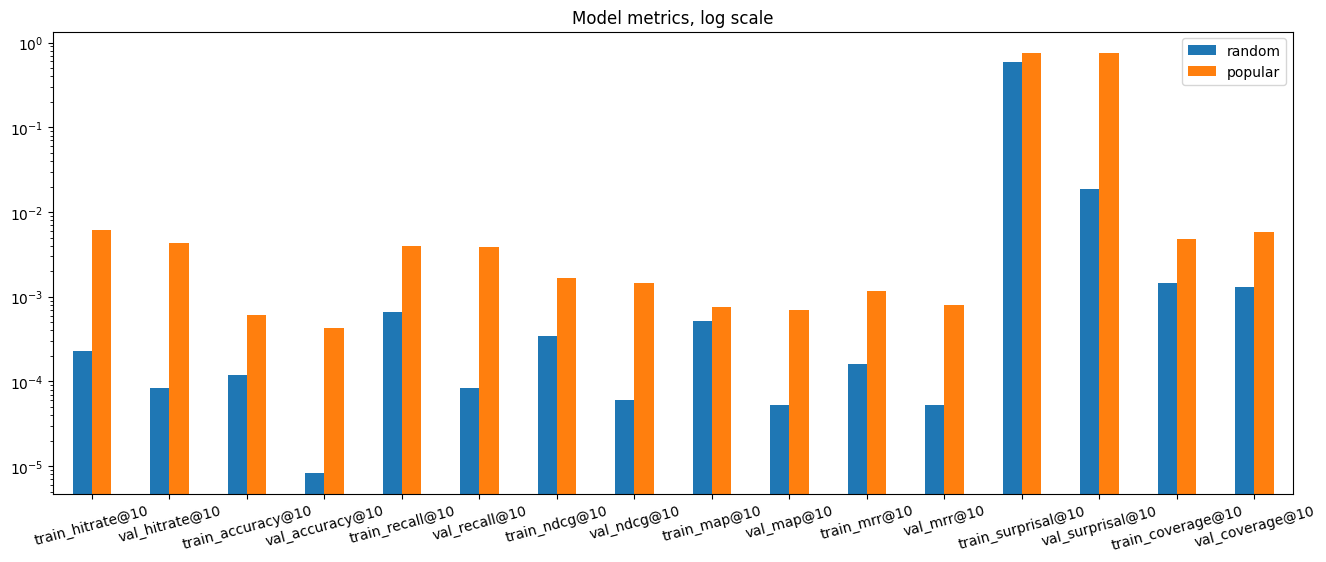

<IPython.core.display.Javascript object>

In [100]:
baseline_models = {
    "random": RandomRecommender(),
    "popular": PopularRecommender(),
}
assessor.assess(baseline_models)
assessor.show_metrics()

### **(1.0 балла) Задание 5.** Метод Memory based. User-2-User or Item-2-Item <span id=**(1.0_балла)_Задание_5.**_Метод_Memory_based._User-2-User_or_Item-2-Item_></span>

Теперь рассмотрим [memory-based](https://en.wikipedia.org/wiki/Collaborative_filtering#Memory-based) методы рекоммендаций.
Подход, лежащий в их основе, использует данные о рейтингах для вычисления сходства между пользователями (user-based) или объектами (item-based), на основе этих данных делаются предсказания рейтингов и, в дальнейшем, строятся рекоммендации. Эти методы просты в реализации и эффективны на ранних стадиях разработки рекомендательных систем.
                                 
              
За последние годы было создано много библиотек для реализации алгоримтов построения рекомендаций.      
  * https://github.com/benfred/implicit
  * https://sberbank-ai-lab.github.io/RePlay/index.html
  * https://github.com/apple/turicreate 
  * https://github.com/caserec/CaseRecommender

Выеберите одну из них и постройте предсказания на основании совместной фильтрации по близости пользователей или по близости объектов.

Если обучение идёт слишком долго подумайте про семплирование данных. Обоснуйте выбранную стратегию семплирования.



In [127]:
import implicit
import pickle
import scipy.sparse

from collections import ChainMap
from scipy.sparse import csr_matrix, coo_matrix
from tqdm.auto import tqdm
from lightfm.data import Dataset


class SparseInterface:
    def __init__(self, data, train_reviews, invalid_org_mark=-1):
        self.data = data
        self.train_reviews = train_reviews
        self.users = self.data["users"]
        self.organisations = self.data["organisations"]
        self.invalid_org_mark = invalid_org_mark

        dataset = Dataset()
        self.fit(dataset)
        self.build_user_features(dataset)
        self.build_item_features(dataset)
        self.build_mapping(dataset)
        self.build_interactions(dataset)

    def build_mapping(self, dataset):
        (
            self.user_id_map,
            self.user_feature_map,
            self.item_id_map,
            self.item_feature_map,
        ) = dataset.mapping()
        self.user_id_map = pd.Series(self.user_id_map)
        item_id_map = pd.Series(self.item_id_map)
        self.item_id_map_reverse = pd.Series(item_id_map.index, item_id_map.values)
        self.item_id_map_reverse[self.invalid_org_mark] = self.invalid_org_mark

    def fit(self, dataset):
        dataset.fit(
            users=self.users["user_id"],
            items=self.organisations["org_id"],
            user_features=self.users["city"].unique(),
            item_features=list(self.organisations["city"].unique())
            + ["average_bill", "rating", "ts"]
            + [f"rubric_{rubric_id}" for rubric_id in self.data["rubrics"]["rubric_id"]]
            + [
                f"feature_{feature_id}"
                for feature_id in self.data["features"]["feature_id"]
            ],
        )

    def build_user_features(self, dataset):
        self.user_features = dataset.build_user_features(
            zip(self.users["user_id"].values, self.users[["city"]].values),
            normalize=False,
        )

    @staticmethod
    def normalize(s):
        return (s - s.mean()) / s.std()

    @staticmethod
    def parse_list_of_feature_ids(feature_ids, name):
        try:
            return {f"{name}_{feature_id}": True for feature_id in feature_ids}
        except TypeError:
            return {}

    @staticmethod
    def extract_org_features(org_row):
        org_features = {
            **{org_row["city"]: True},
            **org_row[["average_bill", "rating", "ts"]].dropna().to_dict(),
            #             **SparseInterface.parse_list_of_feature_ids(
            #                 org_row["rubrics_id"], "rubric"
            #             ),
            #             **SparseInterface.parse_list_of_feature_ids(
            #                 org_row["features_id"], "feature"
            #             ),
        }
        return org_features

    def build_item_features(self, dataset):
        organisations = self.organisations
        organisations["rating"] = self.normalize(organisations["rating"])
        organisations["average_bill"] = self.normalize(organisations["average_bill"])
        organisations["ts"] = self.normalize(
            self.train_reviews.groupby("org_id")["ts"].mean()
        )
        self.item_features = dataset.build_item_features(
            (
                (
                    org_row["org_id"],
                    self.extract_org_features(org_row),
                )
                for org_id, org_row in organisations.iterrows()
            ),
            normalize=False,
        )

    def build_interactions(self, dataset):
        self.interactions, self.interactions_weighted = dataset.build_interactions(
            self.train_reviews[["user_id", "org_id", "rating"]]
            .dropna()
            .astype(np.int32)
            .values
        )

    @staticmethod
    def single_scale_features(features, relative_feature_importance):
        features = features.copy()
        n = features.shape[0]
        features_norm = features[:, n:].sum(axis=1)
        features[:, n:] = csr_matrix(
            features[:, n:].multiply(relative_feature_importance / features_norm)
        )
        return features

    def scale_features(self, relative_feature_importance):
        scaled_user_features = self.single_scale_features(
            self.user_features, relative_feature_importance
        )
        scaled_item_features = self.single_scale_features(
            self.item_features, relative_feature_importance
        )
        return scaled_user_features, scaled_item_features

    def user_ids_to_latent(self, user_ids):
        return self.user_id_map.loc[user_ids]

    def recommended_org_ids_from_latent(self, latent_recommendations):
        recommendations = latent_recommendations.apply(
            lambda s: self.item_id_map_reverse.loc[s].values
        )
        return recommendations

<IPython.core.display.Javascript object>

In [129]:
REUSE = False
DEBUG = True
SAVE = False

if REUSE:
    sparse_interface = pickle.load(
        open(f"local/sparse_interface{'_debug' if DEBUG else ''}.pickle", "rb")
    )
else:
    sparse_interface = SparseInterface(DATA.dataframes, train_reviews)
    if SAVE:
        scipy.sparse.save_npz(
            f"local/train_explicit{'_debug' if DEBUG else ''}.npz",
            sparse_interface.interactions_weighted,
        )

    val_sparse = SparseInterface(DATA.dataframes, validation_reviews)
    if SAVE:
        scipy.sparse.save_npz(
            f"local/val_explicit{'_debug' if DEBUG else ''}.npz",
            val_sparse.interactions_weighted,
        )

    holdout_sparse = SparseInterface(DATA.dataframes, holdout_reviews)
    if SAVE:
        scipy.sparse.save_npz(
            f"local/holdout_explicit{'_debug' if DEBUG else ''}.npz",
            holdout_sparse.interactions_weighted,
        )

        pickle.dump(
            sparse_interface,
            open(f"local/sparse_interface{'_debug' if DEBUG else ''}.pickle", "wb"),
        )

<IPython.core.display.Javascript object>

In [135]:
class SparseRecommender:
    def __init__(self, sparse_interface, model):
        self.model = model
        self.sparse_interface = sparse_interface

    def fit(self, reviews):
        self.interactions = csr_matrix(self.sparse_interface.interactions_weighted)
        self.model.fit(self.interactions)
        return self

    def recommend(self, user_ids, recommend_size=10):
        user_ids_mapped = self.sparse_interface.user_ids_to_latent(user_ids)
        recommendations, predicted_ratings = self.model.recommend(
            userid=user_ids_mapped,
            user_items=self.interactions[user_ids_mapped],
            N=recommend_size,
        )
        recommendations = pd.DataFrame(recommendations, user_ids)
        recommendations = self.sparse_interface.recommended_org_ids_from_latent(
            recommendations
        )
        return torch.from_numpy(recommendations.values)

<IPython.core.display.Javascript object>

In [136]:
nn_models = {
    "tfidf": SparseRecommender(
        sparse_interface, implicit.nearest_neighbours.TFIDFRecommender()
    ),
    "bm25": SparseRecommender(
        sparse_interface, implicit.nearest_neighbours.BM25Recommender()
    ),
    "cosine": SparseRecommender(
        sparse_interface, implicit.nearest_neighbours.CosineRecommender()
    ),
}

assessor.assess(nn_models)

/Users/dimakoshman/YSDA/python3.11_venv/lib/python3.11/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0018439292907714844 seconds
  warnings.warn(


  0%|          | 0/3001 [00:00<?, ?it/s]

/Users/dimakoshman/YSDA/python3.11_venv/lib/python3.11/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0006909370422363281 seconds
  warnings.warn(


  0%|          | 0/3001 [00:00<?, ?it/s]

/Users/dimakoshman/YSDA/python3.11_venv/lib/python3.11/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0006852149963378906 seconds
  warnings.warn(


  0%|          | 0/3001 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

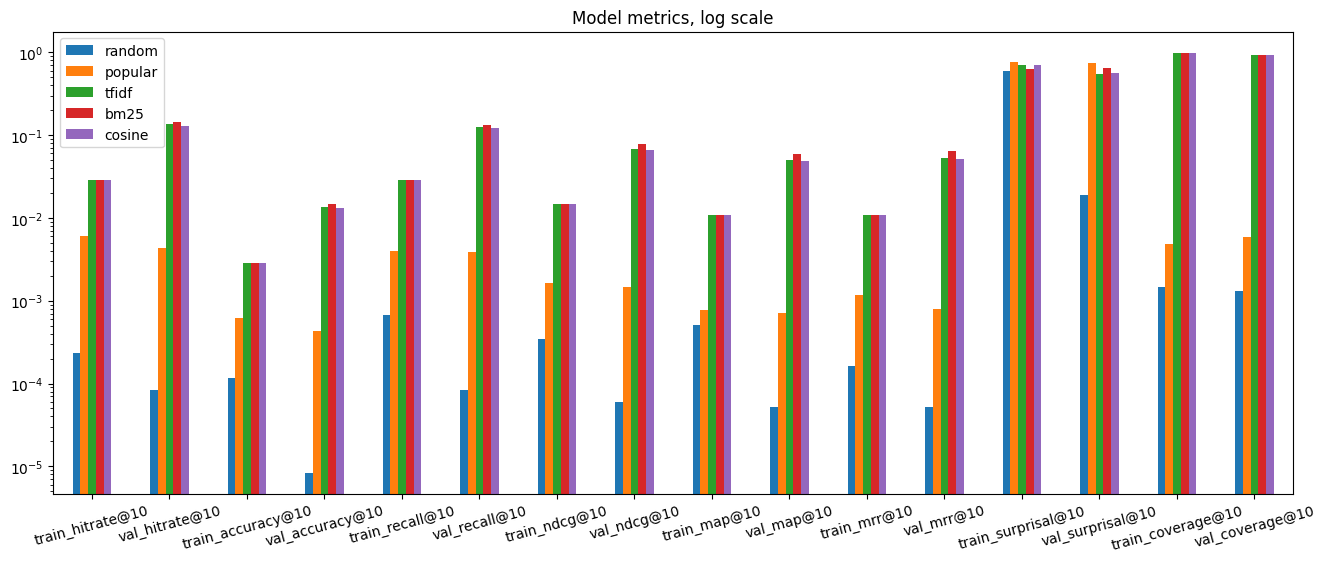

<IPython.core.display.Javascript object>

In [137]:
assessor.show_metrics()

## Методы Matrix factorization

### **(0.5 балла) Задание 6.** <span id=**(0.5_балла)_Задание_6.**_></span>

- Разложите матрицу рейтингов с помощью [разреженного SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) и, восстановив ее, получите предсказания рейтингов для всех пар пользователь-объект. В данном случае неизвестные рейтинги заполняются нулями, а затем восстанавливаются с помощью SVD (этот метод называется PureSVD).
   * Получив векторные представления пользователей и объектов и сингулярные числа, мы можеи восстановив матрицу и в местах нулей получим "предсказанные значения вероятностей" для новых объектов.
- Рассмотрите, как минимум, 5 различных значений ранга разложения. Оцените качество рекомендаций

In [140]:
from sklearn.decomposition import TruncatedSVD


def plot_component_importance(sparse_interface, n_components=100):
    truncated_svd = TruncatedSVD(n_components=n_components)
    truncated_svd.fit(sparse_interface.interactions_weighted)

    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(truncated_svd.explained_variance_ratio_)
    plt.xlabel("n components")
    plt.ylabel("explained variance ratio")
    plt.title("Explained variance depending on number of components")

<IPython.core.display.Javascript object>

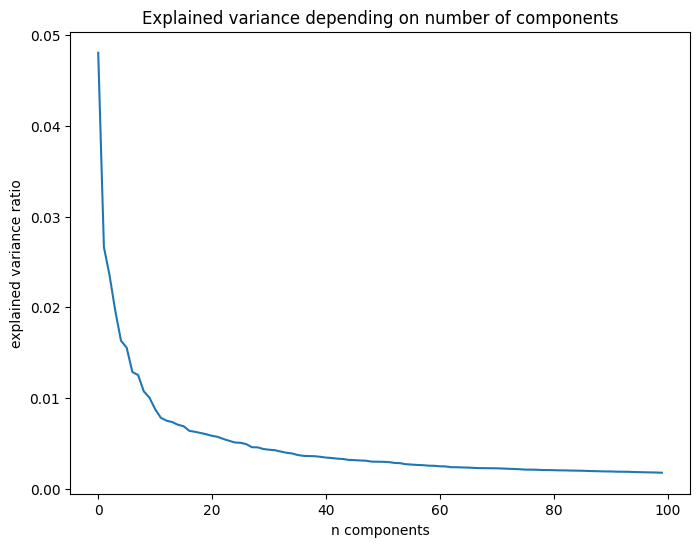

<IPython.core.display.Javascript object>

In [141]:
plot_component_importance(sparse_interface)

In [150]:
class BatchRecommender(SparseRecommender):
    def recommend(self, user_ids, recommend_size=20, batch_size=1024):
        user_ids_mapped = self.sparse_interface.user_ids_to_latent(user_ids)
        interactions = csr_matrix(self.sparse_interface.interactions_weighted)[
            user_ids_mapped
        ]
        recommendations = []

        for begin in tqdm(range(0, len(user_ids), batch_size), "Recommending"):
            batch_slice = slice(begin, begin + batch_size)
            batch_interactions = interactions[batch_slice]
            batch_ids = user_ids[batch_slice]
            batch_ids_mapped = user_ids_mapped[batch_slice]

            batch_rec = self.model_recommend(
                batch_ids_mapped.values, batch_interactions
            )

            if batch_rec.shape[1] > recommend_size:
                if not torch.is_tensor(batch_rec):
                    batch_rec = torch.tensor(batch_rec)
                if torch.cuda.is_available():
                    batch_rec = batch_rec.to("cuda")
                values, indices = torch.topk(batch_rec, recommend_size)
                batch_rec = indices[:, :recommend_size].cpu().numpy()
                del values, indices

            batch_rec = pd.DataFrame(batch_rec, batch_ids)
            recommendations.append(batch_rec)

        recommendations = self.sparse_interface.recommended_org_ids_from_latent(
            pd.concat(recommendations)
        )
        return torch.from_numpy(recommendations.values)

    def model_recommend(self, user_ids, interactions):
        return self.model.recommend(user_ids)


class SVDRecommender(BatchRecommender):
    def model_recommend(self, user_ids, interactions):
        embedding = self.model.transform(interactions)
        recommendations = self.model.inverse_transform(embedding)
        recommendations = torch.from_numpy(recommendations)
        return recommendations

<IPython.core.display.Javascript object>

In [151]:
matrix_factorization_models = {
    f"svd_{n_components}": SVDRecommender(
        sparse_interface, TruncatedSVD(n_components=n_components)
    )
    for n_components in np.logspace(0, 2, num=5, dtype=int)
}

assessor.assess(matrix_factorization_models)
assessor.show_metrics(kind="table")

Recommending:   0%|          | 0/43 [00:00<?, ?it/s]

Recommending:   0%|          | 0/24 [00:00<?, ?it/s]

Recommending:   0%|          | 0/43 [00:00<?, ?it/s]

Recommending:   0%|          | 0/24 [00:00<?, ?it/s]

Recommending:   0%|          | 0/43 [00:00<?, ?it/s]

Recommending:   0%|          | 0/24 [00:00<?, ?it/s]

Recommending:   0%|          | 0/43 [00:00<?, ?it/s]

Recommending:   0%|          | 0/24 [00:00<?, ?it/s]

Recommending:   0%|          | 0/43 [00:00<?, ?it/s]

Recommending:   0%|          | 0/24 [00:00<?, ?it/s]

,train_hitrate@10,val_hitrate@10,train_accuracy@10,val_accuracy@10,train_recall@10,val_recall@10,train_ndcg@10,val_ndcg@10,train_map@10,val_map@10,train_mrr@10,val_mrr@10,train_surprisal@10,val_surprisal@10,train_coverage@10,val_coverage@10
random,0.000232,0.000084,0.000118,0.000008,0.000667,0.000084,0.000349,0.000060,0.000513,0.000053,0.000161,0.000053,0.589673,0.018711,0.001458,0.001302
popular,0.006119,0.004297,0.000614,0.000430,0.004006,0.003890,0.001653,0.001451,0.000763,0.000702,0.001165,0.000789,0.762906,0.745145,0.004861,0.005859
tfidf,0.028325,0.134973,0.002877,0.013704,0.028313,0.126312,0.014853,0.068752,0.010857,0.049888,0.010833,0.053231,0.696657,0.551803,0.994166,0.936198
bm25,0.028325,0.143062,0.002877,0.014668,0.028313,0.132676,0.014853,0.077701,0.010857,0.059029,0.010833,0.063880,0.622541,0.644481,0.968401,0.921875
cosine,0.028325,0.129329,0.002877,0.013152,0.028313,0.121118,0.014853,0.066242,0.010857,0.048297,0.010833,0.051408,0.702746,0.558259,0.990763,0.934245
svd_1,0.170785,0.145168,0.019301,0.014845,0.132657,0.135742,0.087923,0.073655,0.067088,0.053453,0.087996,0.057403,0.413275,0.439720,0.016529,0.015625
svd_3,0.297205,0.204988,0.033508,0.020945,0.233091,0.191219,0.163715,0.116270,0.128899,0.090923,0.170123,0.097602,0.407398,0.451504,0.046184,0.058594
svd_10,0.314728,0.186705,0.036403,0.019033,0.251318,0.173710,0.224048,0.091891,0.199617,0.064932,0.254609,0.069544,0.426061,0.467372,0.053476,0.063802
svd_31,0.421353,0.123810,0.051873,0.012579,0.350588,0.114460,0.337246,0.057662,0.312141,0.039110,0.381882,0.042215,0.498425,0.544658,0.100632,0.132812
svd_100,0.600088,0.066981,0.080358,0.006770,0.531709,0.061458,0.522272,0.030625,0.496419,0.020525,0.567605,0.021987,0.576058,0.626946,0.208070,0.271484


<IPython.core.display.Javascript object>

# ALS
Довольно популярным базовым методом в рекомендательных системах является ALS.

### Explicit ALS

Релевантность:
$$r_{ui} = q_i^T p_u$$

Loss:
$$\min_{p*, q*} \sum_{(u, i \in \mathcal{K})} (r_{ui} - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2)$$

### [Implicit ALS](http://yifanhu.net/PUB/cf.pdf)

Релевантность:
$$r_{ui} = q_i^T p_u$$

Loss:
$$\min_{p*, q*} \sum_{(u, i \in \mathcal{K})} c_{ui}(p_{ui} - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2)$$
Где $c_{ui}$ - значение в матрице implicit feedback, а $p_{ui}$ равно 1, если пользователь u взаимодействовал с item-ом i, и 0 иначе.

### Усложнения ALS
Обучив для каждого пользователя и объекта свой bias и добавив регуляризацию можно улучшить качество решения. Подробнее о различных матричных разложениях для задачи рекомендаций можно почитать [в статье на Хабре](https://habr.com/ru/post/486802/).

В рейтинг объекта для пользователя, например, может быть представлен:
$$r_{ui} = \mu + b_i + b_u + q_i^T p_u$$

А функция потерь будет выглядеть так:
$$\min_{b*, p*, q*} \sum_{(u, i \in \mathcal{K})} (r_{ui} - \mu - b_i - b_u - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2 + b_i^2 + b_u^2)$$

Матричная факторизация - хороший подход, который позволяет получить рекомендации для теплых пользователей, а также находить похожих пользователей и объекты, посчитав расстояния между векторами. Обучив модель и получив вектора можно перейти от задачи рекомендаций к задаче поиска ближайших соседей и использовать ANN-методы.

### **(1.0 балла) Задание 7.** <span id=**(1.0_балла)_Задание_7.**_></span>

Примените ALS.

Можно воспользоваться готовой реализацией из бибилотеки https://github.com/benfred/implicit

Попробуйте использовать как все оценки, так и только высокие. Есть ли разница?

In [169]:
@dataclasses.dataclass
class IndexedCooArray:
    coo_array: scipy.sparse.coo_array
    row_index: np.ndarray
    col_index: np.ndarray

    def __post_init__(self):
        assert self.coo_array.shape == (
            len(self.row_index),
            len(self.col_index),
        ), "Index shapes don't match."

    @property
    def shape(self):
        return self.coo_array.shape

    def get_row_index_series(self):
        return pd.Series(index=self.row_index, data=np.arange(self.shape[0]))

    def __getitem__(self, index):
        coo_array = self.coo_array.tocsr()[index].tocoo()
        row_index = self.row_index[index]
        col_index = self.col_index
        return IndexedCooArray(
            coo_array=coo_array, row_index=row_index, col_index=col_index
        )


def build_weight(*dimensions):
    weight = torch.nn.Parameter(torch.empty(*dimensions))
    torch.nn.init.xavier_normal_(weight)
    return weight


def build_bias(*dimensions):
    bias = torch.nn.Parameter(torch.zeros(*dimensions))
    return bias

<IPython.core.display.Javascript object>

In [197]:
class ImplicitALS(sklearn.base.BaseEstimator):
    def __init__(
        self,
        n_users,
        n_items,
        epochs=10,
        latent_dimension_size=10,
        regularization_lambda=100,
        confidence_alpha=10,
        lambda_decay=0.75,
        num_threads=4,
    ):
        numba.config.NUMBA_NUM_THREADS = num_threads
        numba.config.THREADING_LAYER = "threadsafe"
        numba.set_num_threads(num_threads)

        self.n_users = n_users
        self.n_items = n_items
        self.bias = build_bias(1)
        self.bias.requires_grad = False

        self.user_factors = build_weight(n_users, latent_dimension_size + 2)
        self.user_factors.requires_grad = False
        self.user_factors[:, 0] = 1

        self.item_factors = build_weight(n_items, latent_dimension_size + 2)
        self.item_factors.requires_grad = False
        self.item_factors[:, 1] = 1

        self.epochs = epochs
        self.regularization_lambda = regularization_lambda
        self.confidence_alpha = confidence_alpha
        self.lambda_decay = lambda_decay

        self.confidence_x_preference = None
        self.confidence_minus_1 = None
        self.preference = None

        self.row_index_series: pd.Series or None = None

    def fit(self, train_reviews):
        train_reviews = train_reviews.tocsr()[: self.n_users][:, : self.n_items]
        train_indexed_coo_array = IndexedCooArray(
            train_reviews,
            np.arange(train_reviews.shape[0]),
            np.arange(train_reviews.shape[1]),
        )

        self.row_index_series = train_indexed_coo_array.get_row_index_series()

        self.init_preference_confidence(train_indexed_coo_array.coo_array)

        for _ in tqdm(range(self.epochs), "Alternating"):
            self.on_train_epoch_start()
            self.least_squares_optimization_with_fixed_factors(fixed="items")
            self.least_squares_optimization_with_fixed_factors(fixed="users")
            self.regularization_lambda *= self.lambda_decay

    def init_preference_confidence(self, explicit_feedback):
        implicit_feedback = (explicit_feedback > 0).astype(np.float32)
        self.preference = implicit_feedback
        self.confidence_minus_1 = implicit_feedback * self.confidence_alpha
        self.confidence_minus_1.eliminate_zeros()
        print(self.confidence_minus_1.shape, self.user_factors.shape)
        self.confidence_x_preference = (
            self.confidence_minus_1.multiply(self.preference) + self.preference
        )

    def on_train_epoch_start(self):
        pass

    def least_squares_optimization_with_fixed_factors(
        self, fixed: Literal["users", "items"]
    ):
        kwargs = self.preprocess_optimization_args(fixed=fixed)
        self.analytic_optimum_dispatcher(**kwargs)

    def sparse_iterator(self, transpose=False):
        confidence_minus_1 = self.confidence_minus_1
        confidence_x_preference = self.confidence_x_preference

        if transpose:
            confidence_minus_1 = confidence_minus_1.tocsc()
            confidence_x_preference = confidence_x_preference.tocsc()

        cm1_data = confidence_minus_1.data
        cp_data = confidence_x_preference.data
        indices = confidence_minus_1.indices
        indptr = confidence_minus_1.indptr
        for ptr_id, (ind_begin, ind_end) in enumerate(zip(indptr, indptr[1:])):
            ind_slice = slice(ind_begin, ind_end)
            yield ptr_id, indices[ind_slice], cm1_data[ind_slice], cp_data[ind_slice]

    def preprocess_optimization_args(self, fixed):
        if fixed == "items":
            X = self.user_factors.numpy()
            Y = self.item_factors.numpy()
            X_constant_latent_index = 0
            confidence_minus_1 = self.confidence_minus_1
            confidence_x_preference = self.confidence_x_preference
            sparse_iterator = self.sparse_iterator()

        elif fixed == "users":
            X = self.item_factors.numpy()
            Y = self.user_factors.numpy()
            X_constant_latent_index = 1
            confidence_minus_1 = self.confidence_minus_1.tocsc()
            confidence_x_preference = self.confidence_x_preference.tocsc()
            sparse_iterator = self.sparse_iterator(transpose=True)
        else:
            raise ValueError

        cm1_data = confidence_minus_1.data.astype(np.float32)
        cp_data = confidence_x_preference.data.astype(np.float32)
        indices = confidence_minus_1.indices
        indptr = confidence_minus_1.indptr

        lambda_I = self.regularization_lambda * np.eye(Y.shape[1], dtype=np.float32)
        YtY_plus_lambdaI = Y.T @ Y + lambda_I
        YtY_plus_lambdaI[
            X_constant_latent_index, X_constant_latent_index
        ] -= self.regularization_lambda

        XY_sum = (
            (self.user_factors.sum(axis=0) * self.item_factors.sum(axis=0)).sum().item()
        )

        self.bias[:] = (
            self.confidence_x_preference.sum()
            - XY_sum
            - (
                self.user_factors.T.numpy()
                @ self.confidence_minus_1
                @ self.item_factors.numpy()
            ).sum()
        ) / (self.confidence_minus_1.sum() + np.prod(self.confidence_minus_1.shape))

        return dict(
            X=X,
            Y=Y,
            cm1_data=cm1_data,
            cp_data=cp_data,
            indices=indices,
            indptr=indptr,
            YtY_plus_lambdaI=YtY_plus_lambdaI,
            bias=self.bias.numpy(),
            X_constant_latent_index=X_constant_latent_index,
        )

    @staticmethod
    @numba.njit(parallel=True)
    def analytic_optimum_dispatcher(
        X,
        Y,
        cm1_data,
        cp_data,
        indices,
        indptr,
        YtY_plus_lambdaI,
        bias,
        X_constant_latent_index,
    ):
        for row_id in numba.prange(X.shape[0]):
            ind_slice = slice(indptr[row_id], indptr[row_id + 1])
            if ind_slice.start == ind_slice.stop:
                X[row_id] = 0
                continue

            cm1 = cm1_data[ind_slice]
            cp = cp_data[ind_slice]
            col_indices = indices[ind_slice]
            y = Y[col_indices]

            YtCY_plus_lambdaI = (y.T * cm1) @ y + YtY_plus_lambdaI
            YtCP_minus_biasYtC = y.T @ (cp - bias[0] * cm1 - bias[0])
            X[row_id] = np.linalg.inv(YtCY_plus_lambdaI).astype(np.float32) @ (
                YtCP_minus_biasYtC
            )

        X[:, X_constant_latent_index] = 1

    def predict(self, indexed_coo_array):
        user_ids = self.row_index_series.loc[indexed_coo_array.row_index].values
        ratings = self.user_factors[user_ids] @ self.item_factors.T
        return ratings

    def recommend(self, user_ids, n_recommendations=10):
        ratings = self.user_factors[user_ids] @ self.item_factors.T
        values, indices = torch.topk(ratings, n_recommendations)
        return indices

<IPython.core.display.Javascript object>

In [201]:
my_als_models = {
    "my_als": BatchRecommender(
        sparse_interface,
        ImplicitALS(
            n_users=train_reviews["user_id"].max() + 1,
            n_items=train_reviews["org_id"].max() + 1,
        ),
    ),
}
assessor.assess(my_als_models)
assessor.show_metrics("table")

(305203, 3001) torch.Size([305203, 12])


Alternating:   0%|          | 0/10 [00:00<?, ?it/s]

Recommending:   0%|          | 0/43 [00:00<?, ?it/s]

Recommending:   0%|          | 0/24 [00:00<?, ?it/s]

,train_hitrate@10,val_hitrate@10,train_accuracy@10,val_accuracy@10,train_recall@10,val_recall@10,train_ndcg@10,val_ndcg@10,train_map@10,val_map@10,train_mrr@10,val_mrr@10,train_surprisal@10,val_surprisal@10,train_coverage@10,val_coverage@10
random,0.000232,0.000084,0.000118,0.000008,0.000667,0.000084,0.000349,0.000060,0.000513,0.000053,0.000161,0.000053,0.589673,0.018711,0.001458,0.001302
popular,0.006119,0.004297,0.000614,0.000430,0.004006,0.003890,0.001653,0.001451,0.000763,0.000702,0.001165,0.000789,0.762906,0.745145,0.004861,0.005859
tfidf,0.028325,0.134973,0.002877,0.013704,0.028313,0.126312,0.014853,0.068752,0.010857,0.049888,0.010833,0.053231,0.696657,0.551803,0.994166,0.936198
bm25,0.028325,0.143062,0.002877,0.014668,0.028313,0.132676,0.014853,0.077701,0.010857,0.059029,0.010833,0.063880,0.622541,0.644481,0.968401,0.921875
cosine,0.028325,0.129329,0.002877,0.013152,0.028313,0.121118,0.014853,0.066242,0.010857,0.048297,0.010833,0.051408,0.702746,0.558259,0.990763,0.934245
svd_1,0.170785,0.145168,0.019301,0.014845,0.132657,0.135742,0.087923,0.073655,0.067088,0.053453,0.087996,0.057403,0.413275,0.439720,0.016529,0.015625
svd_3,0.297205,0.204988,0.033508,0.020945,0.233091,0.191219,0.163715,0.116270,0.128899,0.090923,0.170123,0.097602,0.407398,0.451504,0.046184,0.058594
svd_10,0.314728,0.186705,0.036403,0.019033,0.251318,0.173710,0.224048,0.091891,0.199617,0.064932,0.254609,0.069544,0.426061,0.467372,0.053476,0.063802
svd_31,0.421353,0.123810,0.051873,0.012579,0.350588,0.114460,0.337246,0.057662,0.312141,0.039110,0.381882,0.042215,0.498425,0.544658,0.100632,0.132812
svd_100,0.600088,0.066981,0.080358,0.006770,0.531709,0.061458,0.522272,0.030625,0.496419,0.020525,0.567605,0.021987,0.576058,0.626946,0.208070,0.271484


<IPython.core.display.Javascript object>

### **(1.0 балла) Задание 8.** LightFM <span id=**(1.0_балла)_Задание_8.**_LightFM_></span>

На [семинаре](https://github.com/monkey0head/recsys_sem) Вам было расказано про бибилиотеку LightFM.
Примените ее для нашей задачи. Используя фичи и не используя фичи, сравните результат.

In [205]:
from lightfm import LightFM


class LightRecommender(BatchRecommender):
    def __init__(self, *args, feature_importance=1, **kwargs):
        super().__init__(*args, **kwargs)
        self.user_features, self.item_features = self.sparse_interface.scale_features(
            feature_importance
        )

    def fit(self, reviews):
        self.model.fit(
            interactions=self.sparse_interface.interactions,
            sample_weight=self.sparse_interface.interactions_weighted,
            user_features=self.user_features,
            item_features=self.item_features,
            epochs=10,
            num_threads=8,
            verbose=True,
        )
        return self

    def model_recommend(self, user_ids, interactions):
        user_ids, item_ids = np.meshgrid(
            user_ids, range(len(self.sparse_interface.organisations)), indexing="ij"
        )

        recommendations = self.model.predict(
            user_ids=user_ids.flatten(),
            item_ids=item_ids.flatten(),
            user_features=self.user_features,
            item_features=self.item_features,
            num_threads=8,
        ).reshape(user_ids.shape)

        return recommendations

<IPython.core.display.Javascript object>

In [206]:
light_models = {
    f"light_feature_importance_{feature_importance}": LightRecommender(
        sparse_interface, LightFM(), feature_importance=feature_importance
    )
    for feature_importance in [0, 0.1, 0.25, 0.5]
}
assessor.assess(light_models)

Epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 18.07it/s]


Recommending:   0%|          | 0/43 [00:00<?, ?it/s]

Recommending:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 19.22it/s]


Recommending:   0%|          | 0/43 [00:00<?, ?it/s]

Recommending:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.06it/s]


Recommending:   0%|          | 0/43 [00:00<?, ?it/s]

Recommending:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 18.00it/s]


Recommending:   0%|          | 0/43 [00:00<?, ?it/s]

Recommending:   0%|          | 0/24 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [273]:
assessor.show_metrics(kind="table")

,train_hitrate@10,val_hitrate@10,train_accuracy@10,val_accuracy@10,train_recall@10,val_recall@10,train_ndcg@10,val_ndcg@10,train_map@10,val_map@10,train_mrr@10,val_mrr@10,train_surprisal@10,val_surprisal@10,train_coverage@10,val_coverage@10
random,0.000232,0.000084,0.000118,0.000008,0.000667,0.000084,0.000349,0.000060,0.000513,0.000053,0.000161,0.000053,0.589673,0.018711,0.001458,0.001302
popular,0.006119,0.004297,0.000614,0.000430,0.004006,0.003890,0.001653,0.001451,0.000763,0.000702,0.001165,0.000789,0.762906,0.745145,0.004861,0.005859
tfidf,0.028325,0.134973,0.002877,0.013704,0.028313,0.126312,0.014853,0.068752,0.010857,0.049888,0.010833,0.053231,0.696657,0.551803,0.994166,0.936198
bm25,0.028325,0.143062,0.002877,0.014668,0.028313,0.132676,0.014853,0.077701,0.010857,0.059029,0.010833,0.063880,0.622541,0.644481,0.968401,0.921875
cosine,0.028325,0.129329,0.002877,0.013152,0.028313,0.121118,0.014853,0.066242,0.010857,0.048297,0.010833,0.051408,0.702746,0.558259,0.990763,0.934245
svd_1,0.170785,0.145168,0.019301,0.014845,0.132657,0.135742,0.087923,0.073655,0.067088,0.053453,0.087996,0.057403,0.413275,0.439720,0.016529,0.015625
svd_3,0.297205,0.204988,0.033508,0.020945,0.233091,0.191219,0.163715,0.116270,0.128899,0.090923,0.170123,0.097602,0.407398,0.451504,0.046184,0.058594
svd_10,0.314728,0.186705,0.036403,0.019033,0.251318,0.173710,0.224048,0.091891,0.199617,0.064932,0.254609,0.069544,0.426061,0.467372,0.053476,0.063802
svd_31,0.421353,0.123810,0.051873,0.012579,0.350588,0.114460,0.337246,0.057662,0.312141,0.039110,0.381882,0.042215,0.498425,0.544658,0.100632,0.132812
svd_100,0.600088,0.066981,0.080358,0.006770,0.531709,0.061458,0.522272,0.030625,0.496419,0.020525,0.567605,0.021987,0.576058,0.626946,0.208070,0.271484


<IPython.core.display.Javascript object>

Light with features scores terribly because it recommends based on features and ratings, while the metrics are only based on known ratings. So it should be better at recommending new items for users, but requires different metrics to evaluate.

---

### **(1.0 балла) Задание 9.** Catboost. <span id=**(1.0_балла)_Задание_9.**_Catboost._></span>

   Посмотрим на все прошлые методы как на модели, которые генерируют нам кандидатов для ответа рекомендательной системы. 
   
   Как нам выбрать те 20 организаций наилучшим образом? 
   
   Давайте подключим машинное обучение. Сформуллируем задачу ранжирования: запросом будет пользователь. Документами будут организации. Наивным призаковым описанием будет, например, факт рекомендации данной органицзаии или скор/ранг от моделей SVD, ALS, LightFM.
   Примените catboost/xgboost/lightgbm для создания переранжирования рекомендаций. То есть сделаем двухуровневую модель. Выясните, наиболее важные признаки моделей перевого уровня.

In [240]:
from catboost import Pool, CatBoostRanker


@numba.njit
def jit_user_ranks(user_id, recommended_org_ids, relevance, k):
    """
    :param user_id: id of user to generate ranks for
    :param recommended_org_ids: array of org_ids
    of shape [k * n_models] that were recommended by n_models,
    sorted by decreasing predicted relevance
    :param relevance: array of shape [k * n_models] of
    true relevance of corresponding orgs
    :param k: how many recommendations each model generated

    :returns: array R of shape (n_unique_org_ids, k + 3),
    in zeroth column the repeated user_id,
    in first unique_org_ids,
    in second the true relevance of unique org to user,
    in R[i, 3 + j] is the rank of org i that was assigned
    to it by j-th model, if it was recommended at all, otherwise -1
    """
    unique_org_ids = np.unique(recommended_org_ids)
    org_id_map = dict()
    for i, org_id in enumerate(unique_org_ids):
        org_id_map[org_id] = i

    rankings = np.full((len(unique_org_ids), len(recommended_org_ids) // k + 3), -1)
    rankings[:, 0] = user_id
    rankings[:, 1] = unique_org_ids

    for i, (org_id, rel) in enumerate(zip(recommended_org_ids, relevance)):
        row_id = org_id_map[org_id]
        rankings[row_id, 2] = rel
        rankings[row_id, i // k + 3] = i % k
    return rankings


@numba.njit
def jit_rankings_per_user(user_ids, recommendations, relevance, k=10):
    """Returns list of jit_user_ranks for each user."""
    rankings = []
    for user_id, rec, rel in zip(user_ids, recommendations, relevance):
        rankings.append(jit_user_ranks(user_id, rec, rel, k))
    return rankings


def recommendations_data_to_ranking(assessor, model_names):
    """
    Transforms recommendations of all assessed models
    into rankings and then into catboost Pool object,
    ready to be used for catboost ranking training.

    Pool data is grouped by users, true labels are the
    true relevance of each org_id, features are categorical,
    each model corresponds a category, value of a category is
    the rank assigned by the model if it was recommended
    at all and -1 otherwise.
    """
    ranking_data = {}
    for dataset, metric, users in zip(
        ["train", "val"],
        [assessor.train_metrics, assessor.val_metrics],
        [assessor.train_users, assessor.validation_users],
    ):
        recommendations = []
        relevance = []

        for model_name in model_names:
            recommendation = assessor.assessments[model_name][
                f"{dataset}_recommendations"
            ]
            recommendations.append(pd.DataFrame(recommendation, index=users))
            relevance.append(
                binary_relevance(
                    explicit_feedback=metric.explicit_feedback,
                    recommendee_user_ids=users,
                    recommendations=recommendation.numpy(),
                )
            )

        recommendations = pd.concat(recommendations, axis="columns")
        relevance = np.hstack(relevance)
        rankings = jit_rankings_per_user(
            recommendations.index.to_numpy(), recommendations.values, relevance
        )
        rankings = np.vstack(rankings)

        rankings = pd.DataFrame(
            rankings, columns=["user_id", "org_id", "relevance"] + model_names
        )
        ranking_data[dataset] = {
            "pool": Pool(
                data=rankings.drop(["user_id", "org_id", "relevance"], axis="columns"),
                cat_features=model_names,
                label=rankings["relevance"].values,
                group_id=rankings["user_id"].values,
            ),
            "relevance": rankings[["user_id", "org_id", "relevance"]],
        }

    return ranking_data

<IPython.core.display.Javascript object>

In [268]:
ranking_data = recommendations_data_to_ranking(
    assessor,
    model_names=["bm25", "svd_100", "my_als", "light_feature_importance_0.1"],
)

<IPython.core.display.Javascript object>

In [276]:
def assess_cb(assessor, ranking_data):
    cb_ranker = CatBoostRanker(task_type="CPU", train_dir="local")
    cb_ranker.fit(ranking_data["train"]["pool"], verbose=False)
    cb_relevance = cb_ranker.predict(ranking_data["val"]["pool"])

    cb_recommendations = pd.concat(
        [
            ranking_data["val"]["relevance"],
            pd.Series(cb_relevance, name="cb_relevance"),
        ],
        axis="columns",
    )
    cb_recommendations = cb_recommendations.groupby("user_id").apply(
        lambda df: df.sort_values("cb_relevance", ascending=False)["org_id"]
        .iloc[:10]
        .values
    )
    cb_recommendations = torch.from_numpy(np.stack(cb_recommendations.values))
    print(cb_recommendations.shape)
    cb_val_metrics = pd.Series(
        assessor.val_metrics.metrics(
            torch.from_numpy(assessor.validation_users), cb_recommendations
        )
    ).rename("catboost")
    metrics = pd.concat(
        [i["val_metrics"] for i in assessor.assessments.values()] + [cb_val_metrics],
        axis="columns",
    )
    return cb_ranker, metrics

<IPython.core.display.Javascript object>

In [277]:
cb_ranker, metrics = assess_cb(assessor, ranking_data)
metrics.T.style.background_gradient(cmap="coolwarm", low=0.5, high=0.5)

torch.Size([23738, 10])


,hitrate@10,accuracy@10,recall@10,ndcg@10,map@10,mrr@10,surprisal@10,coverage@10
random,0.000084,0.000008,0.000084,0.000060,0.000053,0.000053,0.018711,0.001302
popular,0.004297,0.000430,0.003890,0.001451,0.000702,0.000789,0.745145,0.005859
tfidf,0.134973,0.013704,0.126312,0.068752,0.049888,0.053231,0.551803,0.936198
bm25,0.143062,0.014668,0.132676,0.077701,0.059029,0.063880,0.644481,0.921875
cosine,0.129329,0.013152,0.121118,0.066242,0.048297,0.051408,0.558259,0.934245
svd_1,0.145168,0.014845,0.135742,0.073655,0.053453,0.057403,0.439720,0.015625
svd_3,0.204988,0.020945,0.191219,0.116270,0.090923,0.097602,0.451504,0.058594
svd_10,0.186705,0.019033,0.173710,0.091891,0.064932,0.069544,0.467372,0.063802
svd_31,0.123810,0.012579,0.114460,0.057662,0.039110,0.042215,0.544658,0.132812
svd_100,0.066981,0.006770,0.061458,0.030625,0.020525,0.021987,0.626946,0.271484


<IPython.core.display.Javascript object>

In [271]:
def calculate_feature_importance(cb_ranker, ranking_data):
    importance = cb_ranker.get_feature_importance(ranking_data["val"]["pool"])
    importance = pd.Series(importance, cb_ranker.feature_names_).rename(
        "cb feature importance"
    )
    importance = importance.to_frame().style.background_gradient(
        cmap="coolwarm", low=0.5, high=0.5
    )
    return importance

<IPython.core.display.Javascript object>

In [272]:
calculate_feature_importance(cb_ranker, ranking_data)

,cb feature importance
bm25,-0.161157
svd_100,-0.508511
my_als,-0.044145
light_feature_importance_0.1,0.010438


<IPython.core.display.Javascript object>